In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report
import warnings
warnings.filterwarnings('ignore')

Çalışmamda gerekli olacak olan kütüphaneleri yükledim.

In [2]:
df = pd.read_csv('water_potability.csv')



1. ph: pH değeri 1'dir. su (0 ila 14).
2. Sertlik: Suyun sabunu mg / L cinsinden çökeltme kapasitesi.
3. Katılar: Ppm cinsinden toplam çözünmüş katılar.
4. Kloraminler: Ppm cinsinden Kloramin miktarı.
5. Sülfat: Mg / L'de çözünmüş Sülfat Miktarı.
6. İletkenlik: Suyun µS / cm cinsinden elektriksel iletkenliği.
7. Organik karbon: Ppm cinsinden organik karbon miktarı.
8. Trihalometanlar: Μg / L cinsinden Trihalometan Miktarı.
9. Bulanıklık: Ntu'da suyun ışık yayma özelliğinin ölçüsü.
10. İçilebilirlik: Suyun insan tüketimi için güvenli olup olmadığını gösterir. İçilebilir -1 ve içilebilir değil -0*   List item


Veri setimi yükledim ve özelliklerin anlamlarını araştırdım.

In [3]:
display(df.head())

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


Veri setinin ilk 10 satırını görüntüledim ve ilk bakışta sülfat sütununda boş değerler olduğunu gördüm.

In [4]:
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

Bütün sütunlardaki boş değerleri gözlemledim.

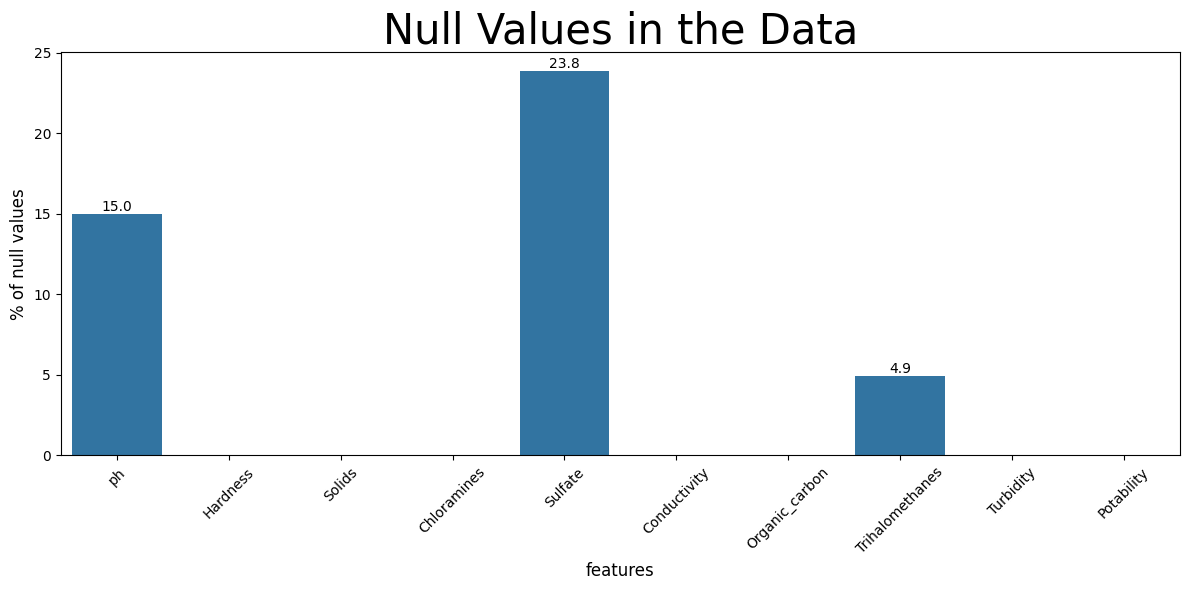

In [5]:
data_nulls = (df.apply(lambda x: x.isnull().value_counts()).T[True]/len(df)*100).reset_index(name='count')


fig = plt.figure(figsize=(12,6))

fig = sns.barplot(data_nulls, x="index", y="count")
fig.set_title('Null Values in the Data', fontsize=30)
fig.set_xlabel('features', fontsize=12)
fig.set_xticklabels(fig.get_xticklabels(), rotation=45)
fig.set_ylabel('% of null values', fontsize=12)
fig.bar_label(fig.containers[0], fmt='%.1f')

plt.tight_layout()

Boş değerleri grafikleştirdim.

In [6]:
missing_data_summary = df.isnull().sum().sort_values(ascending=False).to_frame(name='MissingCount')
missing_data_summary['MissingPercentage'] = (missing_data_summary['MissingCount'] / len(df)) * 100
print(missing_data_summary)

                 MissingCount  MissingPercentage
Sulfate                   781          23.840049
ph                        491          14.987790
Trihalomethanes           162           4.945055
Hardness                    0           0.000000
Solids                      0           0.000000
Chloramines                 0           0.000000
Conductivity                0           0.000000
Organic_carbon              0           0.000000
Turbidity                   0           0.000000
Potability                  0           0.000000


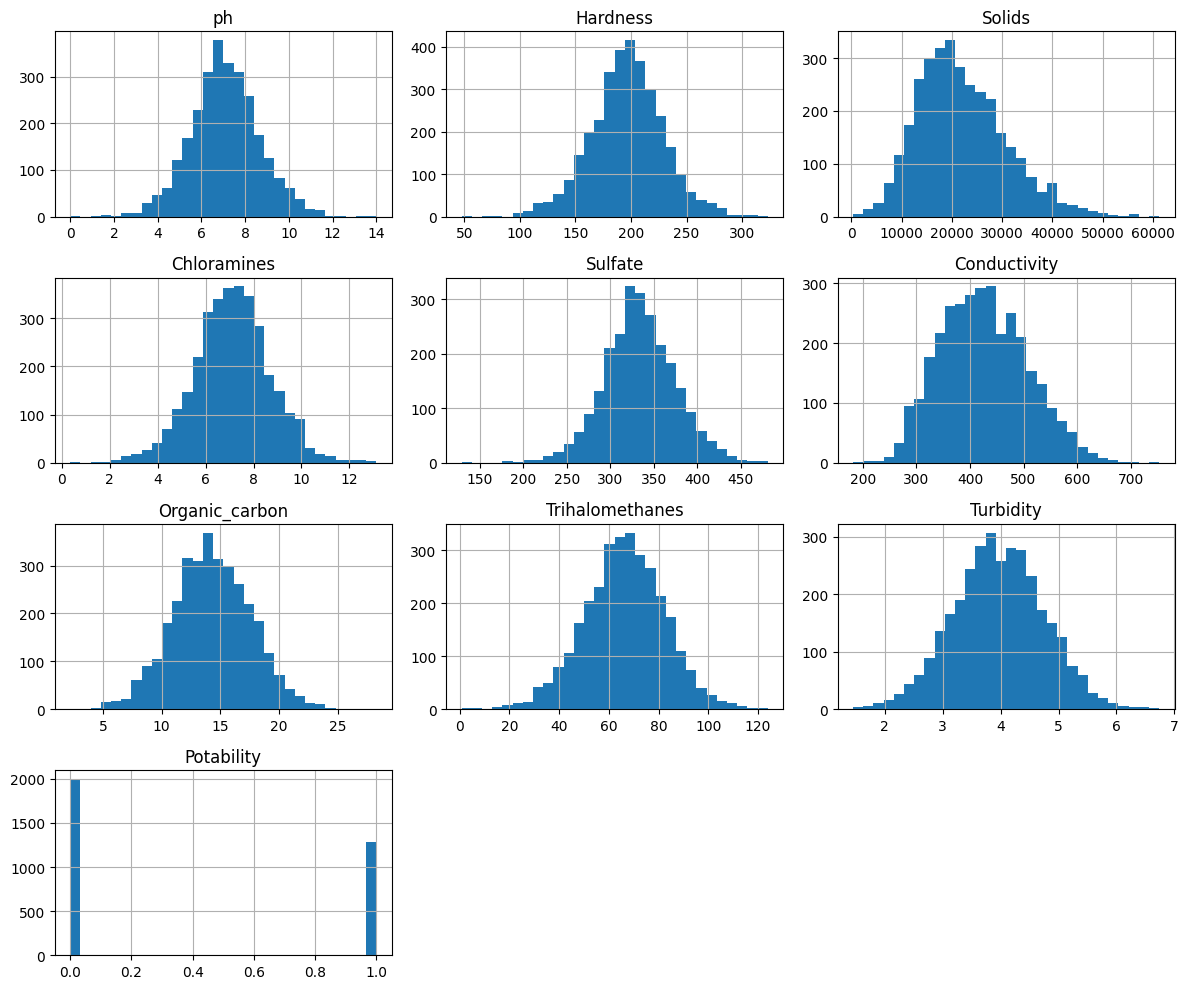

In [7]:
# Sayısal kolonların dağılımı
df.hist(figsize=(12, 10), bins=30)
plt.tight_layout()
plt.show()

Sayısal sütunların dağılımlarını inceledim.

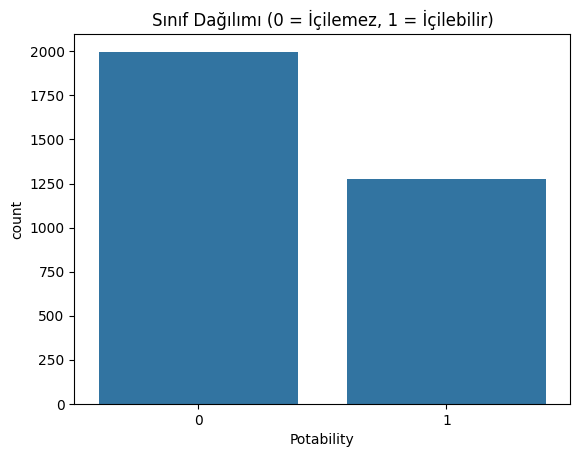

In [8]:
# Sınıf dağılımı
sns.countplot(data=df, x="Potability")
plt.title("Sınıf Dağılımı (0 = İçilemez, 1 = İçilebilir)")
plt.show()

Ayriyetten veri seti içindeki suyun ne kadarının içilebilir ne kadarının değil olduğını görmek için tablo oluşturdum.

In [9]:
display(df.describe())

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


Veri setindeki max, min değerleri ve ortalamaları inceledim.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


Veri setindeki sütunların veri tiplerini gözlemledim.

In [11]:
outliers_perc = []

print('### Percentage of outliers in the columns ###')
print()


def outliers_perc_search(data, cols):
    for k,v in data[cols].items():
        # Column must be of numeric type (not object)
        if data[k].dtype != 'O':
            q1 = v.quantile(0.25)
            q3 = v.quantile(0.75)
            irq = q3 - q1
            v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
            perc = np.shape(v_col)[0] * 100.0 / np.shape(data)[0]
            out_tuple = (k,int(perc))
            outliers_perc.append(out_tuple)
            print("Column %s outliers = %.1f%%" % (k,perc))


outliers_perc_search(df, cols=df.columns)

### Percentage of outliers in the columns ###

Column ph outliers = 1.4%
Column Hardness outliers = 2.5%
Column Solids outliers = 1.4%
Column Chloramines outliers = 1.9%
Column Sulfate outliers = 1.3%
Column Conductivity outliers = 0.3%
Column Organic_carbon outliers = 0.8%
Column Trihalomethanes outliers = 1.0%
Column Turbidity outliers = 0.6%
Column Potability outliers = 0.0%


In [12]:
#aykırı degerleri baskılama

def cap_outliers(df):
    for col in df.select_dtypes(include=np.number).columns[:-1]:  # target hariç
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower, lower,
                           np.where(df[col] > upper, upper, df[col]))
    return df

df = cap_outliers(df)

In [13]:
df['ph'] = df['ph'].fillna(df.groupby('Potability')['ph'].transform('mean'))
df['Sulfate'] = df['Sulfate'].fillna(df.groupby('Potability')['Sulfate'].transform('mean'))
df['Trihalomethanes'] = df['Trihalomethanes'].fillna(df.groupby('Potability')['Trihalomethanes'].transform('mean'))

In [14]:
# Enerji/yoğunluk bazlı yeni öznitelikler
df["mineral_density"] = (df["Solids"] + df["Hardness"]) / (df["Conductivity"] + 0.01)
df["ph_conductivity_interaction"] = df["ph"] * df["Conductivity"]
df["ph_div_turbidity"] = df["ph"] / (df["Turbidity"] + 0.01)

# Zararlı madde baskınlığı
df["chloramine_ratio_total_chem"] = df["Chloramines"] / (df["Trihalomethanes"] + df["Organic_carbon"] + 0.01)
df["tri_to_organic_ratio"] = df["Trihalomethanes"] / (df["Organic_carbon"] + 0.01)
df["sulfate_to_total_dissolved"] = df["Sulfate"] / (df["Solids"] + df["Conductivity"] + 0.01)

# Yumuşatma-sertlik etkisi
df["hardness_ratio"] = df["Hardness"] / (df["ph"] + df["Turbidity"] + 0.01)
df["hard_ph_turb_mix"] = df["Hardness"] * df["ph"] * df["Turbidity"]

# Kimyasal yoğunluk puanı
df["chem_density_score"] = (
    df["Chloramines"]**0.5 +
    df["Trihalomethanes"]**0.5 +
    df["Organic_carbon"]**0.5
)

# İkili farklar
df["sulfate_minus_conductivity"] = df["Sulfate"] - df["Conductivity"]
df["solids_minus_organic"] = df["Solids"] - df["Organic_carbon"]
df["ph_minus_trihalo"] = df["ph"] - df["Trihalomethanes"]

# normalize edilmiş kombinasyonlar
df["normalized_conductivity"] = df["Conductivity"] / df["Conductivity"].max()
df["normalized_toxicity"] = (
    df["Chloramines"]/df["Chloramines"].max() +
    df["Trihalomethanes"]/df["Trihalomethanes"].max()
)

# Zıt etkili ürünler
df["ph_x_inverse_turbidity"] = df["ph"] * (1 / (df["Turbidity"] + 0.01))
df["sulfate_div_logsolids"] = df["Sulfate"] / (np.log1p(df["Solids"]))


Sayısal sütunlardaki aykırı değerlerin yüzdelik oranlarını gözlemledim.

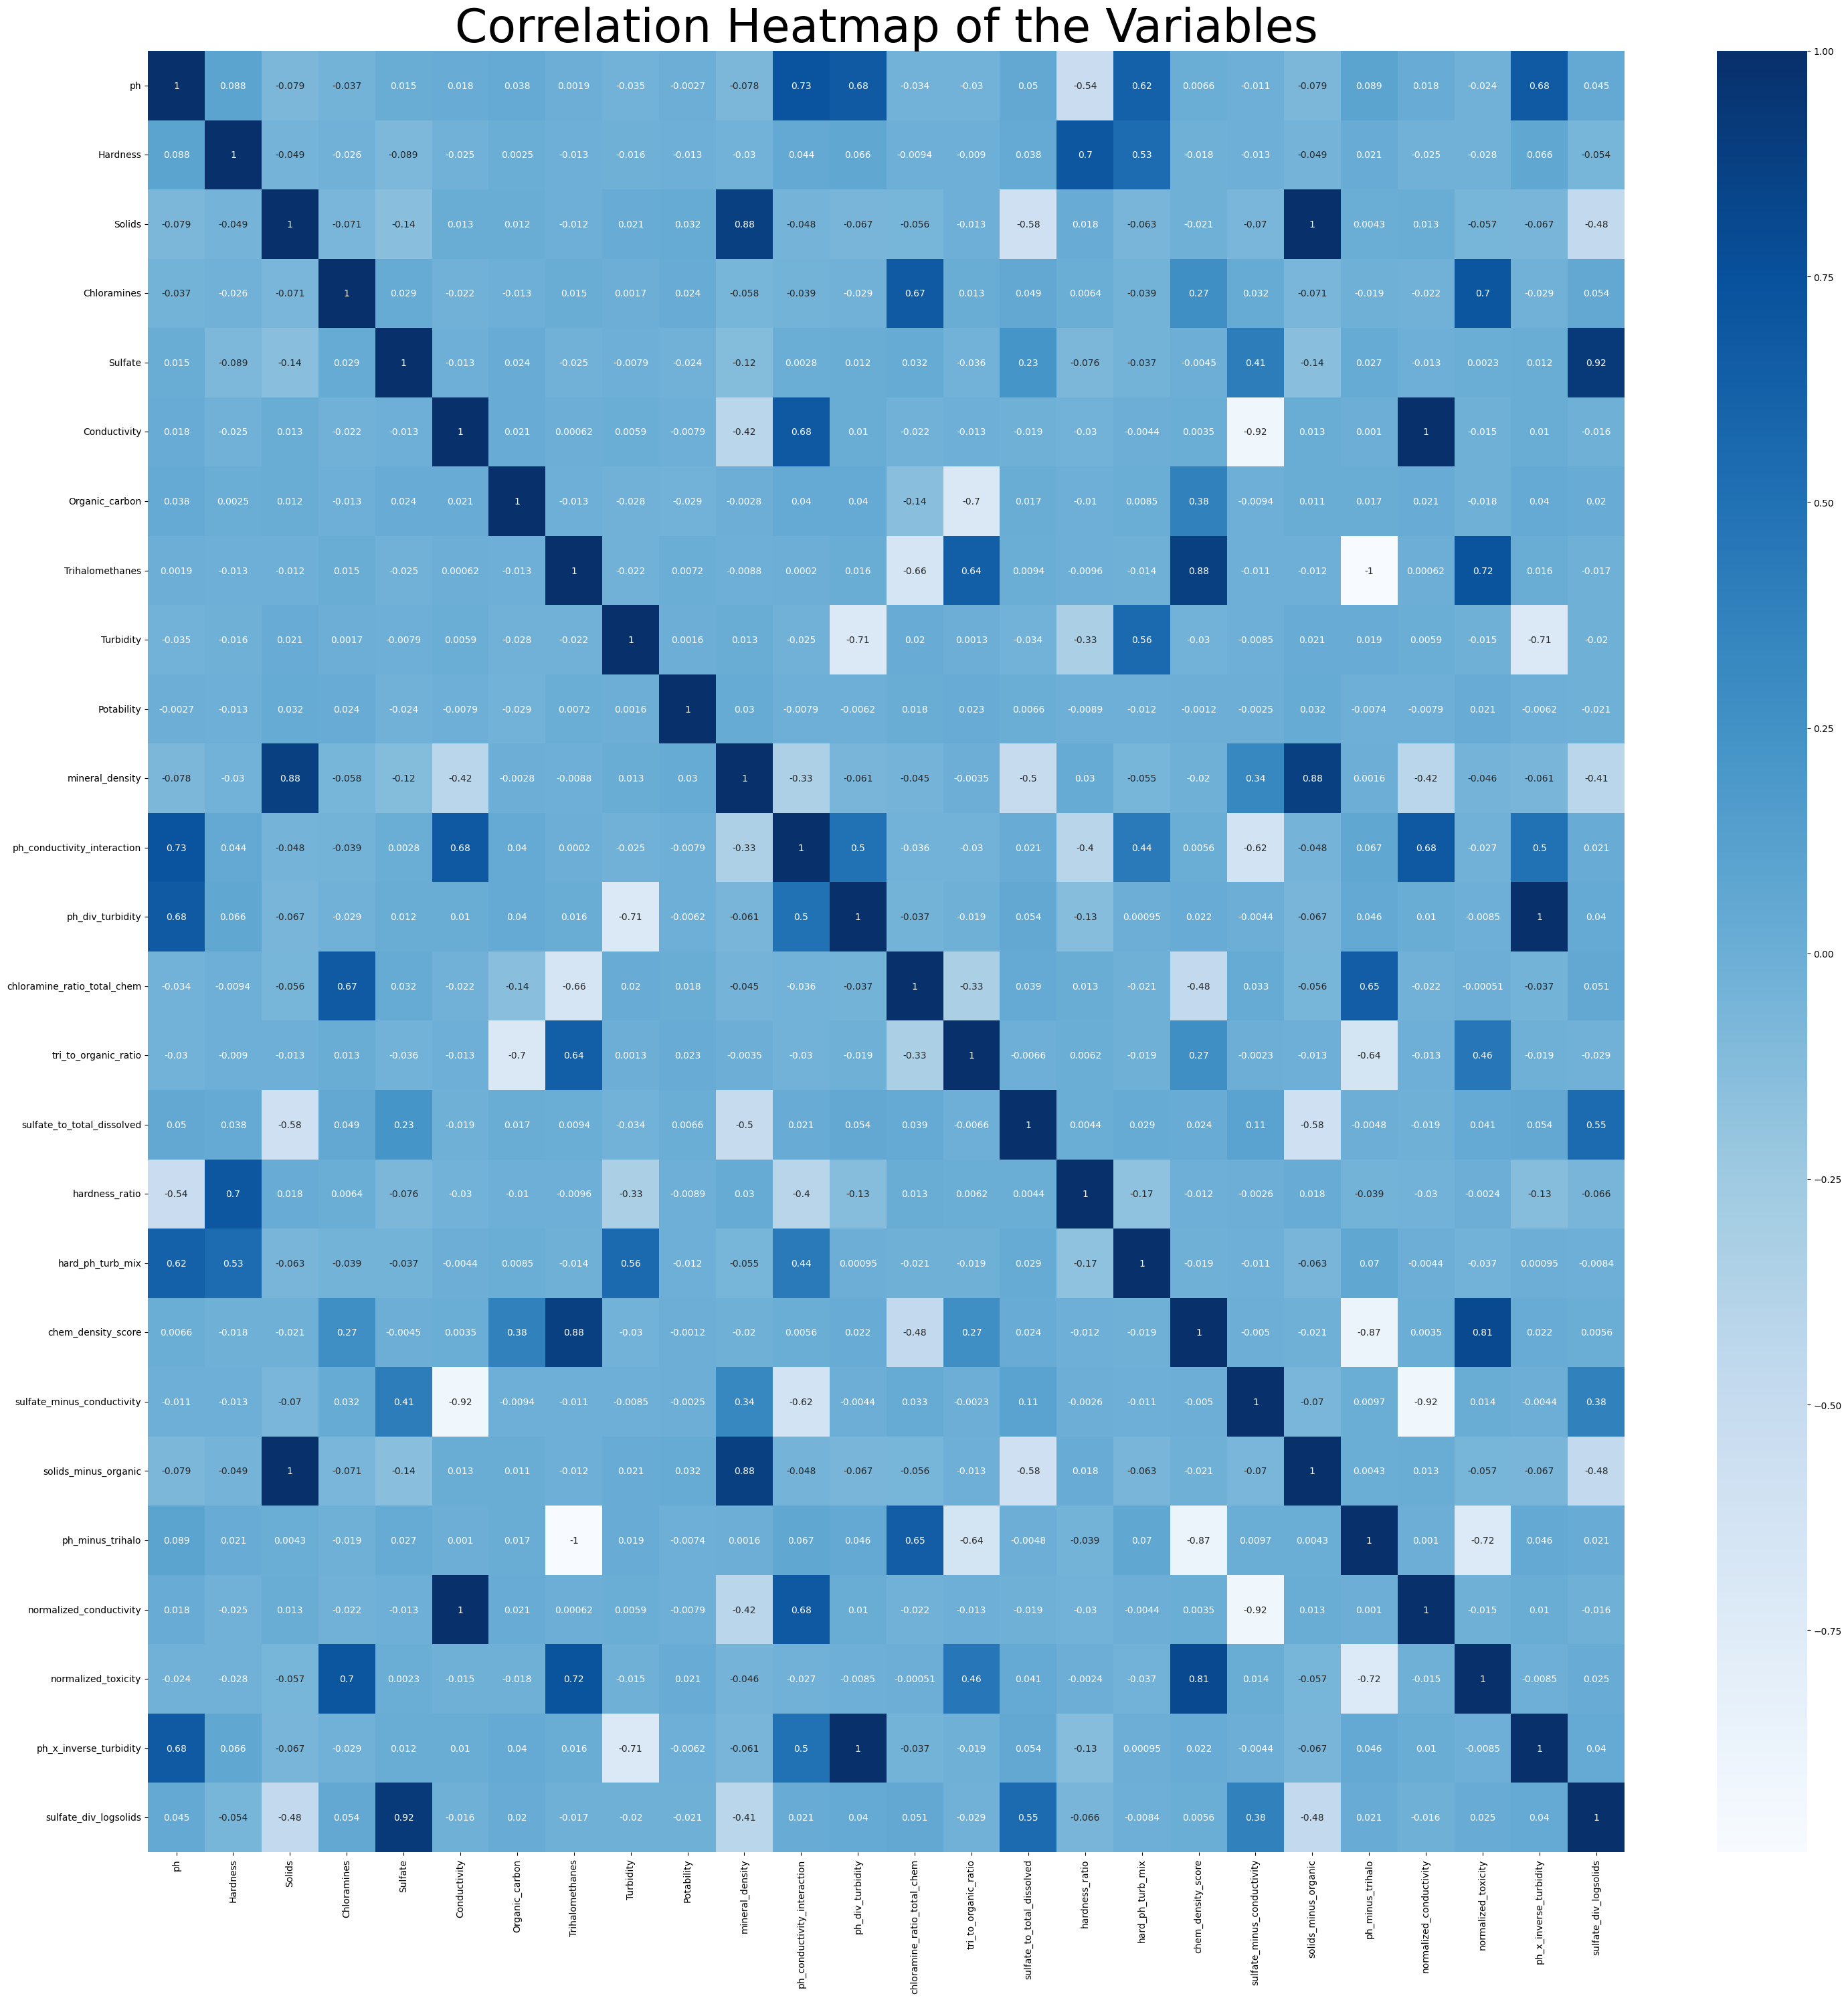

In [15]:
fig = plt.figure(figsize=(30,30))

fig = sns.heatmap(df.corr(), annot=True, cmap='Blues')
fig.set_title('Correlation Heatmap of the Variables', size=50)

plt.tight_layout()

Değişkenlerin birbirleriyle olan bağlantılarını görmek için korelasyon matrisi oluşturdum.

In [16]:
df.isnull().sum()

ph                             0
Hardness                       0
Solids                         0
Chloramines                    0
Sulfate                        0
Conductivity                   0
Organic_carbon                 0
Trihalomethanes                0
Turbidity                      0
Potability                     0
mineral_density                0
ph_conductivity_interaction    0
ph_div_turbidity               0
chloramine_ratio_total_chem    0
tri_to_organic_ratio           0
sulfate_to_total_dissolved     0
hardness_ratio                 0
hard_ph_turb_mix               0
chem_density_score             0
sulfate_minus_conductivity     0
solids_minus_organic           0
ph_minus_trihalo               0
normalized_conductivity        0
normalized_toxicity            0
ph_x_inverse_turbidity         0
sulfate_div_logsolids          0
dtype: int64

In [17]:
display(df.describe())

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability,...,hardness_ratio,hard_ph_turb_mix,chem_density_score,sulfate_minus_conductivity,solids_minus_organic,ph_minus_trihalo,normalized_conductivity,normalized_toxicity,ph_x_inverse_turbidity,sulfate_div_logsolids
count,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,...,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000
mean,7.081779,196.392423,21957.112200,7.121794,333.876096,426.129974,14.283462,66.414614,3.966612,0.390110,...,18.123179,5522.642658,14.494595,-92.253877,21942.828738,-59.332835,0.649708,1.247930,1.860334,33.784262
std,1.428755,32.017189,8592.820397,1.544126,35.301585,80.564144,3.288367,15.590035,0.776409,0.487849,...,3.949705,1846.985461,1.120158,88.373545,8592.782169,15.652650,0.122834,0.200534,0.570576,4.142322
min,3.139631,117.125160,320.942611,3.146221,229.323489,191.647579,5.328026,23.605130,1.848797,0.000000,...,7.588925,1044.388204,10.349948,-390.532029,300.521139,-105.859175,0.292200,0.585175,0.569090,21.410697
25%,6.277673,176.850538,15666.690297,6.127421,317.094638,365.734414,12.065801,56.647656,3.439711,0.000000,...,15.725487,4224.367207,13.783468,-153.473266,15651.327091,-69.629403,0.557625,1.114796,1.472223,31.613274
50%,7.084849,196.967627,20927.833607,7.130299,334.562558,421.884968,14.218338,66.324969,3.955028,0.000000,...,17.806318,5368.525598,14.568780,-88.228680,20915.355522,-59.348306,0.643236,1.252649,1.775396,33.582727
75%,7.870050,216.667456,27332.762127,8.114887,350.385756,481.792304,16.557652,76.666609,4.500320,1.000000,...,20.177327,6610.250906,15.248719,-27.120055,27315.573575,-49.534178,0.734575,1.381447,2.164276,35.897040
max,11.015527,276.392834,44831.869873,11.096086,438.326179,655.879140,23.295427,109.576879,6.091233,1.000000,...,40.569145,15966.572483,17.565369,169.526721,44826.541847,-14.302689,1.000000,1.892221,4.960359,60.669497


In [18]:
X = df.drop('Potability', axis=1)
y = df['Potability']
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
# 7. SMOTE ile sınıf dengesi sağla

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

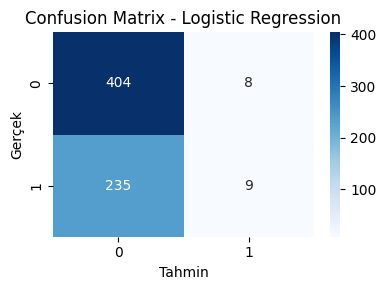

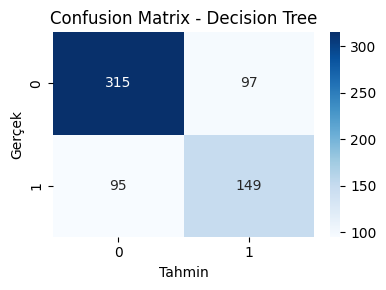

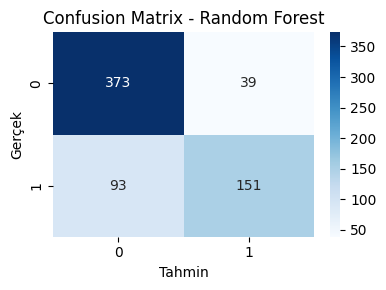

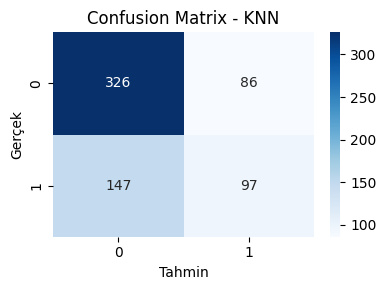

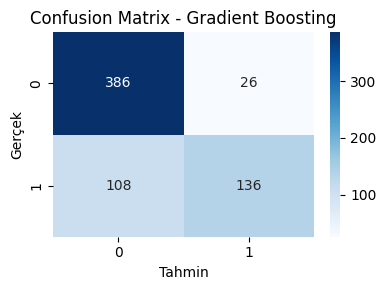

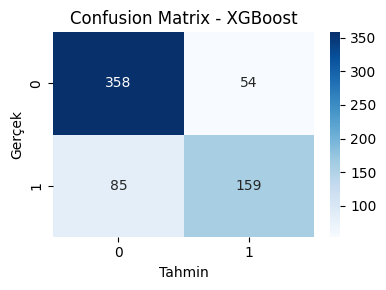

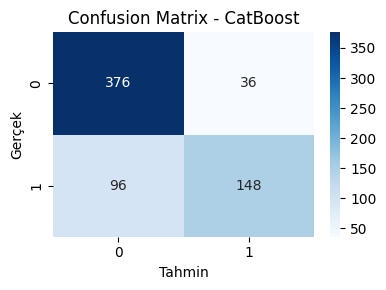

                 Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0        Random Forest     0.799      0.795   0.619     0.696    0.841
1              XGBoost     0.788      0.746   0.652     0.696    0.864
2             CatBoost     0.799      0.804   0.607     0.692    0.886
3    Gradient Boosting     0.796      0.840   0.557     0.670    0.879
4        Decision Tree     0.707      0.606   0.611     0.608    0.688
5                  KNN     0.645      0.530   0.398     0.454    0.638
6  Logistic Regression     0.630      0.529   0.037     0.069    0.521


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score

models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "CatBoost": CatBoostClassifier(verbose=0),
}

results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    precision = report['1']['precision']
    recall = report['1']['recall']
    f1 = report['1']['f1-score']
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    results.append({
        "Model": name,
        "Accuracy": round(accuracy, 3),
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1 Score": round(f1, 3),
        "ROC AUC": round(roc_auc, 3)
    })

    # Confusion Matrix çiz
    plt.figure(figsize=(4, 3))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Tahmin")
    plt.ylabel("Gerçek")
    plt.tight_layout()
    plt.show()

# Sonuç tablosu
results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False).reset_index(drop=True)
print(results_df)


In [21]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# XGBoost modelini başlat
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Parametre aralığı
distributions = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Randomized Search ile en iyi parametreleri ara
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=distributions,
    n_iter=10,
    scoring='f1',
    cv=3,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

# Eğitim verisi ile fit et
random_search.fit(X_train_resampled, y_train_resampled)

# En iyi modeli al
best_xgb = random_search.best_estimator_

# Tahmin yap ve metrikleri hesapla
y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:, 1]

report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
f1 = report['1']['f1-score']
recall = report['1']['recall']
precision = report['1']['precision']
roc_auc = roc_auc_score(y_test, y_proba)

# Sonuçları yazdır
print("\nXGBoost (Tuned) Sonuçları")
print(f"F1 Score: {round(f1, 3)}")
print(f"Recall: {round(recall, 3)}")
print(f"Precision: {round(precision, 3)}")
print(f"ROC AUC: {round(roc_auc, 3)}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits

XGBoost (Tuned) Sonuçları
F1 Score: 0.702
Recall: 0.738
Precision: 0.669
ROC AUC: 0.853


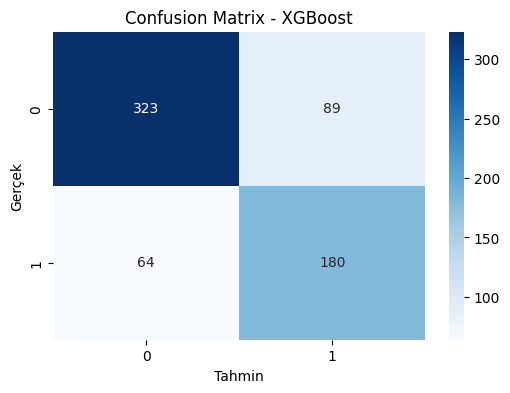

In [22]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.show()


In [23]:


# CatBoost modelini başlat
catboost_model = CatBoostClassifier(verbose=0, random_state=42)

# Parametre aralığı
distributions = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'iterations': [100, 200, 300],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

# Randomized Search ile en iyi parametreleri ara
random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=distributions,
    n_iter=10,
    scoring='f1',
    cv=3,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

# Eğitim verisi ile fit et
random_search.fit(X_train_resampled, y_train_resampled)

# En iyi modeli al
best_catboost = random_search.best_estimator_

# Tahmin yap ve metrikleri hesapla
y_pred = best_catboost.predict(X_test)
y_proba = best_catboost.predict_proba(X_test)[:, 1]

report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
f1 = report['1']['f1-score']
recall = report['1']['recall']
precision = report['1']['precision']
roc_auc = roc_auc_score(y_test, y_proba)

# Sonuçları yazdır
print("\nCatBoost (Tuned) Sonuçları")
print(f"F1 Score: {round(f1, 3)}")
print(f"Recall: {round(recall, 3)}")
print(f"Precision: {round(precision, 3)}")
print(f"ROC AUC: {round(roc_auc, 3)}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits

CatBoost (Tuned) Sonuçları
F1 Score: 0.718
Recall: 0.758
Precision: 0.683
ROC AUC: 0.869


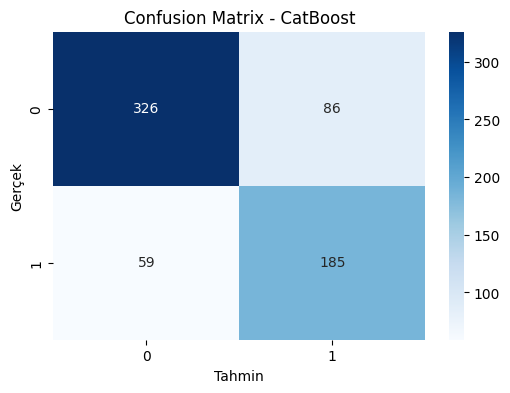

In [24]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - CatBoost")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.show()


In [3]:
pip install streamlit

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


SyntaxError: invalid syntax (927876576.py, line 1)